In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
!ls

Mounted at /content/drive
drive  sample_data


In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.3MB 13.8MB/s 


In [ ]:
!pip install -q tf-models-official

     |████████████████████████████████| 1.6MB 13.9MB/s 
     |████████████████████████████████| 37.2MB 127kB/s 
     |████████████████████████████████| 686kB 43.2MB/s 
     |████████████████████████████████| 215kB 44.1MB/s 
     |████████████████████████████████| 358kB 47.3MB/s 
     |████████████████████████████████| 1.2MB 43.3MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 102kB 9.7MB/s 
     |████████████████████████████████| 645kB 33.8MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 


In [31]:
import os
import shutil
import random
from tqdm import tqdm
import gc

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors

tf.get_logger().setLevel('ERROR')
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

In [ ]:
SEED = 2021
seed_everything(SEED)

In [ ]:
def read_and_preprocess():
    df = pd.read_csv('/content/drive/MyDrive/shopee/shopee-product-matching/train.csv')
    tmp = df.groupby(['label_group'])['posting_id'].unique().to_dict()
    df['matches'] = df['label_group'].map(tmp)
    df['matches'] = df['matches'].apply(lambda x: ' '.join(x))
    encoder = LabelEncoder()
    df['label_group'] = encoder.fit_transform(df['label_group'])
    N_CLASSES = df['label_group'].nunique()
    print(f'We have {N_CLASSES} classes')
    x_train, x_val, y_train, y_val = train_test_split(df[['title','posting_id']], df['label_group'], shuffle = True, stratify = df['label_group'], random_state = SEED, test_size = 0.33)
    return df, N_CLASSES, x_train, x_val, y_train, y_val
df, N_CLASSES, x_train, x_val, y_train, y_val = read_and_preprocess()

We have 11014 classes


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train['title'].values, y_train.values))
train_dataset = train_dataset.batch(32)
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.prefetch(AUTOTUNE)

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_val['title'].values, y_val.values))
val_dataset = val_dataset.batch(32)
val_dataset = val_dataset.prefetch(AUTOTUNE)

In [ ]:
for text_batch, label_batch in train_dataset.take(1):
  print(text_batch, label_batch)

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(N_CLASSES, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
text_test = ['this is such an amazing movie!']
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))
classifier_model.summary()

tf.Tensor([[0.49582693 0.5068373  0.631283   ... 0.5430101  0.45434874 0.47789338]], shape=(1, 11014), dtype=float32)


In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.SparseCategoricalAccuracy()

In [ ]:
epochs = 60
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                      num_train_steps=num_train_steps,
                      num_warmup_steps=num_warmup_steps,
                      optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x = train_dataset, 
                validation_data = val_dataset, 
                epochs = epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/60
718/718 [==============================] - 150s 203ms/step - loss: 9.3260 - sparse_categorical_accuracy: 8.7157e-05 - val_loss: 9.2981 - val_sparse_categorical_accuracy: 1.7694e-04
Epoch 2/60
718/718 [==============================] - 145s 202ms/step - loss: 9.2655 - sparse_categorical_accuracy: 6.5368e-04 - val_loss: 9.2532 - val_sparse_categorical_accuracy: 0.0036
Epoch 3/60
718/718 [==============================] - 144s 201ms/step - loss: 9.1719 - sparse_categorical_accuracy: 0.0071 - val_loss: 9.1653 - val_sparse_categorical_accuracy: 0.0170
Epoch 4/60
718/718 [==============================] - 144s 201ms/step - loss: 9.0272 - sparse_categorical_accuracy: 0.0176 - val_loss: 9.0228 - val_sparse_categorical_accuracy: 0.0215
Epoch 5/60
718/718 [==============================] - 144s 201ms/step - loss: 8.8258 - sparse_categorical_accuracy: 0.0221 - val_loss: 8.8191 - val_sparse_categ

In [ ]:
saved_model_path = '/content/drive/MyDrive/shopee/bert_model/bert.h5'
classifier_model.save_weights(saved_model_path)

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


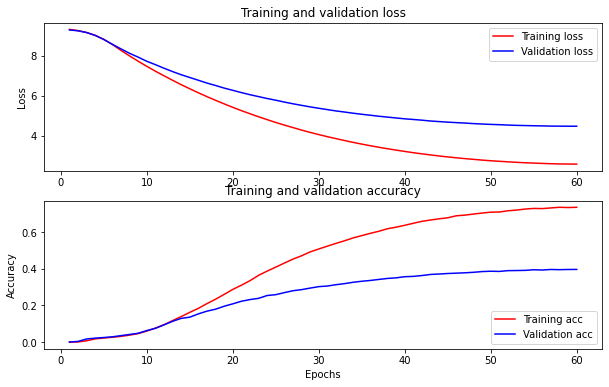

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
def f1_score(y_true, y_pred):
  y_true = y_true.apply(lambda x: set(x.split()))
  y_pred = y_pred.apply(lambda x: set(x.split()))
  intersection = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
  len_y_pred = y_pred.apply(lambda x: len(x)).values
  len_y_true = y_true.apply(lambda x: len(x)).values
  f1 = 2 * intersection / (len_y_pred + len_y_true)
  return f1

In [ ]:
reconstructed_model = build_classifier_model()
reconstructed_model.load_weights(saved_model_path)
# 重新取输入和输出 选取embedding层作为输出
reconstructed_model = tf.keras.models.Model(inputs = reconstructed_model.input, 
                        outputs = reconstructed_model.layers[-2].output) 
reconstructed_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'pooled_output': (N 28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

In [ ]:
embeds = []
for text_batch, labels_batch in tqdm(val_dataset):
  embeds.append(reconstructed_model.predict(text_batch))

In [ ]:
text_embeddings = np.concatenate(embeds)

In [ ]:
text_embeddings.shape

(11303, 512)

In [ ]:
def get_neighbors(df, embeddings, KNN=50, threshold = 4.5):

    model = NearestNeighbors(n_neighbors = KNN)
    model.fit(embeddings)
    distances, indices = model.kneighbors(embeddings)
    
    predictions = []
    for k in tqdm(range(embeddings.shape[0])):
        idx = np.where(distances[k,] < threshold)[0]
        ids = indices[k,idx]
        posting_ids = df['posting_id'].iloc[ids].values
        predictions.append(posting_ids)
        
    del model, distances, indices
    gc.collect()
    return df, predictions

In [32]:
df_test_pred, text_predictions = get_neighbors(x_val, text_embeddings, KNN = 50)

100%|██████████| 11303/11303 [00:01<00:00, 7867.14it/s]


In [33]:
def combine_predictions(row):
  # x = np.concatenate([row['image_predictions'], row['text_predictions']])
  x = row['text_predictions']
  return ' '.join(np.unique(x))

In [37]:
#df_test_pred['image_predictions'] = image_predictions
df_test_pred['text_predictions'] = text_predictions
df_test_pred['matches'] = df_test_pred.apply(combine_predictions, axis=1)
df_test_pred[['posting_id', 'matches']].to_csv('/content/drive/MyDrive/shopee/submission.csv', index=False)

In [39]:
df_test_pred.head()

,title,posting_id,text_predictions,matches
15319,LAMPU LED PHILIPS 12 WATT 12WATT 12W 12 W KEMA...,train_2332310353,[train_2332310353],train_2332310353
13540,OMGENDUT Xylophone Mainan,train_290486421,[train_290486421],train_290486421
28794,Garnier Micellar Water Bi-Phase Skin Care - 40...,train_658477378,[train_658477378],train_658477378
17937,RAK GANTUNG SERBAGUNA / Storage Decorative Rac...,train_4130879443,[train_4130879443],train_4130879443
8639,\xe3\x80\x90 COD \xe3\x80\x91 Botol Spray / Fl...,train_1217495101,[train_1217495101],train_1217495101


In [40]:
df_test_pred = pd.read_csv('/content/drive/MyDrive/shopee/submission.csv')

In [41]:
df_test_pred.head()

,posting_id,matches
0,train_2332310353,train_2332310353
1,train_290486421,train_290486421
2,train_658477378,train_658477378
3,train_4130879443,train_4130879443
4,train_1217495101,train_1217495101


In [42]:
df_test_pred['f1'] = f1_score(df_test_pred['posting_id'], df_test_pred['matches'])

In [43]:
df_test_pred['f1'].mean()

0.9585294928755242